# Supplementary figures

### This notebook includes the code to reproduce the supplementary figures (Figure S1 to S4).

Figure S1: The probability of exceeding 2.0ºC warming threshold for the three SSP scenarios;

Figure S2: The probability of exceeding 3.0ºC warming threshold for the three SSP scenarios;

Figure S3: The probability of short-term and prolonged GMST increase greater than the temperature thresholds between 0.1ºC and 0.9ºC by 2100.

Figure S4: SAOD, ERF, and GMST anomalies of the EVA_H + FaIR simulation and UKESM simulation (from Chim et al., 2023) for the three stochastic scenarios (at the 2.5th, 50.0th and 98th percentiles).

---------------


Written by May Chim

Last updated: 7 August 2024

---------------

## Import packages and figure adjustments

In [1]:
import palettable
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.patches as patches

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rc('font', size=16)        
plt.rc('axes', titlesize=16) 
plt.rc('axes', labelsize=16)  
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)  
plt.rc('legend', fontsize=14)   
plt.rc('figure', titlesize=20) 

## Functions

In [3]:
def calc_prob_temp_threshold(df,ssp,thres):
    
    # Function to calculate probability of exceeding warming thresholds
    
    count_num = []
    
    for t in range(87):
        
        # for each year from 2015 to 2101
        # count number of stochastic scenarios exceeding the temperature threshold
        
        count_num.append(np.sum(df[t,ssp,:] > thres).values/1000*100)

    return count_num # returns probability in percentage

In [4]:
def calc_surtemp(df):
    temp = df
    
    weights = np.cos(np.deg2rad(temp.latitude))
    weights.name = "weights"

    # Weighted mean
    temp_w = temp.weighted(weights)

    # Global mean monthly temp
    temp_globalmean = temp_w.mean(dim=['latitude','longitude'])

    # Global annual mean
    temp_global_annual = temp_globalmean.groupby('time.year').mean('time')

    return temp_global_annual

def calc_historical_surtemp_ens(df1, df2, df3):
    
    df1_temp = calc_surtemp(df1.air_temperature[0:612,:,:])
    df2_temp = calc_surtemp(df2.air_temperature[0:612,:,:])
    df3_temp = calc_surtemp(df3.air_temperature[0:612,:,:])
    
    df_ens = ((df1_temp+df2_temp+df3_temp)/3).mean(dim='year')
    
    return df_ens

## Read data

In [6]:
# Directory of data files

#Set path
#os.chdir('<path-to-directory-of-data>')

### Read FaIR simulation results

# Future projection with 1000-member stochastic volcanic forcing scenarios and internal variability
df2 = xr.open_dataset('stochastic_volcanoes_stochastic_climate.nc')

# Future projection with constant volcanic forcing (CMIP6 ScenarioMIP)
dn = xr.open_dataset('no_future_volcanoes.nc')

# Future projection with 5 stochastic scenarios under SSP370 (ukesm calibrated FaIR runs)
ukesm_cali = xr.open_dataset('ukesm_calibration_five_scenarios.nc')

# Read data for Figure S3
df_occurrence = pd.read_csv('table_prob_occurrence_warming.csv')
df_prolonged_warming = pd.read_csv('table_prolonged_warming.csv')

In [7]:
### UKESM data from Chim et al (2023)

#Set path
#os.chdir('<path-to-directory-of-data>')

# Annual mean GMST, UKESM SSP370
volc25_grl = xr.open_dataset('volc2_5_annual_surtemp.nc')
volc50_1_grl = xr.open_dataset('volc50_1_annual_surtemp.nc')
volc98_grl = xr.open_dataset('volc98_annual_surtemp.nc')

# Monthly mean GMST, UKESM historical
hist1 = xr.open_dataset('u-by791_monthly_volc_airtemp.nc')
hist2 = xr.open_dataset('u-bz502_monthly_volc_airtemp.nc')
hist3 = xr.open_dataset('u-bz897_monthly_volc_airtemp.nc')
hist_ens = calc_historical_surtemp_ens(hist1, hist2, hist3)
    
# Annual mean net radiative forcing, UKESM SSP370
RF_volc25 = xr.open_dataset('volc2_5_annual_net_radiative_forcing_at_TOA.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')
RF_volc50_1 = xr.open_dataset('volc50_1_annual_net_radiative_forcing_at_TOA.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')
RF_volc98 = xr.open_dataset('volc98_annual_net_radiative_forcing_at_TOA.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')
RF_novolc = xr.open_dataset('novolc_annual_net_radiative_forcing_at_TOA.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')

# Monthly mean SAOD, UKESM SSP370
saod_volc25 = xr.open_dataset('volc2_5_monthly_saod.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')
saod_volc50_1 = xr.open_dataset('volc50_1_monthly_saod.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')
saod_volc98 = xr.open_dataset('volc98_monthly_saod.nc').__xarray_dataarray_variable__.mean(dim='Ensemble Member')

In [17]:
# Read monthly mean SAOD and ERF volcanic forcing input files

#Set path
#dir_in = '<path-to-directory-of-data>/Monthly_forcing_files_v2/'

df_saod = []
df_erf = []
df_ens = []

for filename in os.listdir(dir_in):

    if filename.endswith(".csv"):
        
        match = re.search(r'\d+', filename)
        if match:
            file_numbers = match.group()
            file_path = os.path.join(dir_in, filename)
            df = pd.read_csv(file_path)
            saod_mean = df['Global monthly mean SAOD at 550nm'].mean()
            erf_mean = df['Global monthly mean TOA ERF (W/m2)'].mean()
            
            df_ens.append(file_numbers)
            df_saod.append(saod_mean)
            df_erf.append(erf_mean)

data = {'ensemble': df_ens, 'saod_mean': df_saod, 'erf_mean': df_erf}
combined_df = pd.DataFrame(data)

# 2.5th, 5th, median, 95th and 97.5th percentile values of SAOD distribution
saod_median = combined_df['saod_mean'].median()
saod_2_5_percentile = combined_df['saod_mean'].quantile(0.025)
saod_5_percentile = combined_df['saod_mean'].quantile(0.05)
saod_95_percentile = combined_df['saod_mean'].quantile(0.95)
saod_97_5_percentile = combined_df['saod_mean'].quantile(0.975)

# 2.5th, 5th, median, 95th and 97.5th percentile values of ERF distribution
erf_median = combined_df['erf_mean'].median()
erf_2_5_percentile = combined_df['erf_mean'].quantile(0.025)
erf_5_percentile = combined_df['erf_mean'].quantile(0.05)
erf_95_percentile = combined_df['erf_mean'].quantile(0.95)
erf_97_5_percentile = combined_df['erf_mean'].quantile(0.975)

# Stochastic scenario at 2.5th percentile
temp_saod_file = pd.read_csv(dir_in+'forcing_monthly_scen65.csv')
saod_volc25_time_series = temp_saod_file['Global monthly mean SAOD at 550nm']

# Stochastic scenario at 50.0th percentile
temp_saod_file = pd.read_csv(dir_in+'forcing_monthly_scen824.csv')
saod_volc50_time_series = temp_saod_file['Global monthly mean SAOD at 550nm']

# Stochastic scenario at 98th percentile
temp_saod_file = pd.read_csv(dir_in+'forcing_monthly_scen364.csv')
saod_volc98_time_series = temp_saod_file['Global monthly mean SAOD at 550nm']

# Read annual mean ERF derived using Marshall et al. (2020)
#Set path
#dir_in = '<path-to-directory-of-data>/Yearly_forcing_files_v2/'

# Stochastic scenario at 2.5th percentile
temp_saod_file = pd.read_csv(dir_in+'forcing_yearly_scen65.csv')
erf_volc25_time_series = temp_saod_file['Global yearly mean TOA ERF (W/m2)']

# Stochastic scenario at 50.0th percentile
temp_saod_file = pd.read_csv(dir_in+'forcing_yearly_scen824.csv')
erf_volc50_time_series = temp_saod_file['Global yearly mean TOA ERF (W/m2)']

# Stochastic scenario at 98th percentile
temp_saod_file = pd.read_csv(dir_in+'forcing_yearly_scen364.csv')
erf_volc98_time_series = temp_saod_file['Global yearly mean TOA ERF (W/m2)']


## Figure S1

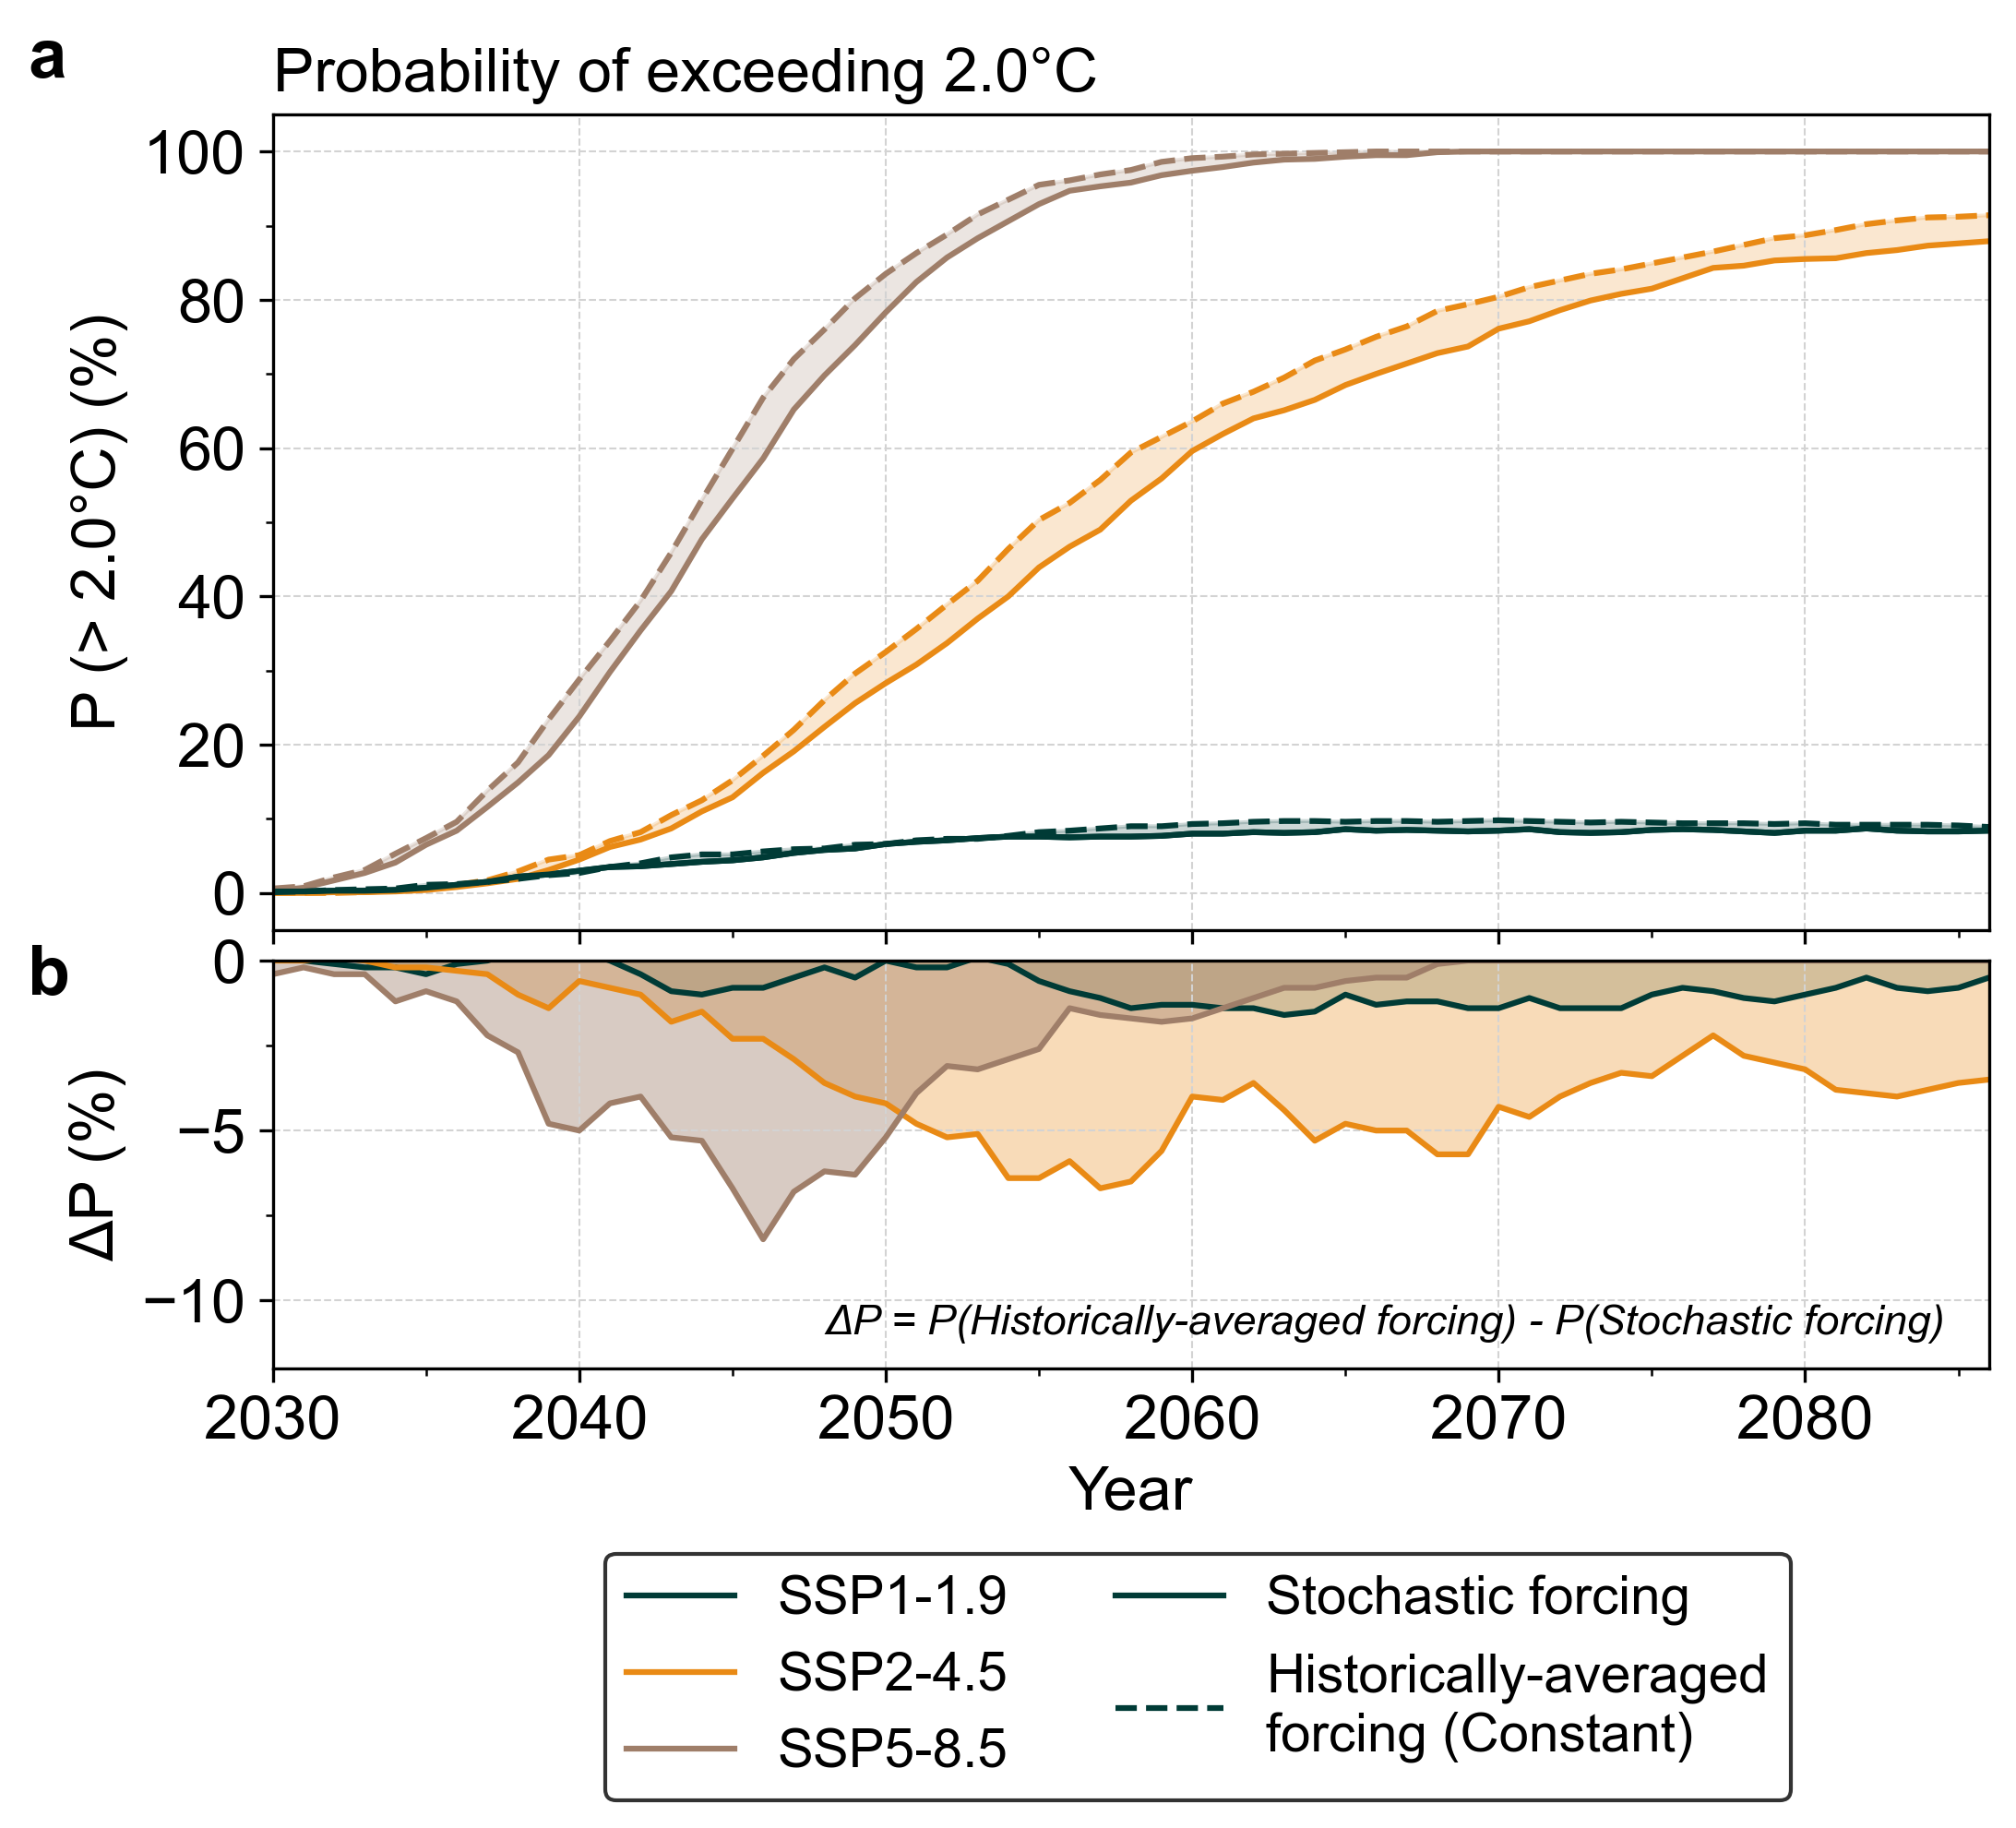

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=300, gridspec_kw={'height_ratios': [2, 1]})
grid_settings = {'color': 'lightgray', 'linestyle': '--', 'linewidth': 0.5}

plt.subplots_adjust(hspace=0.05)
ax1.grid(True, **grid_settings)
ax2.grid(True, **grid_settings)

ax1.minorticks_on()
ax2.minorticks_on()

ax1.xaxis.set_minor_locator(ticker.MultipleLocator(5)) 
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))


df = df2.temperature[165:,:,:].rolling(timebounds=30, center = True).mean()
const = dn.temperature[165:,:,:].rolling(timebounds=30, center = True).mean()

time = np.arange(2015,2102,1)

color = ['#003B36', '#E98A15', '#9F7E69']

temp = 2.0

ax1.plot(time, calc_prob_temp_threshold(df, 0, temp), color=color[0], lw = 1.5, label='SSP1-1.9')
ax1.fill_between(time, calc_prob_temp_threshold(df, 0, temp), calc_prob_temp_threshold(const, 0, temp), 
                 color=color[0], alpha=0.2)


ax1.fill_between(time, calc_prob_temp_threshold(df, 1, temp), calc_prob_temp_threshold(const, 1, temp), 
                 color=color[1], alpha=0.2)
ax1.plot(time, calc_prob_temp_threshold(df, 1, temp), color=color[1], lw = 1.5, label='SSP2-4.5')
ax1.plot(time, calc_prob_temp_threshold(const, 1, temp), color=color[1], lw = 1.5, ls='--')

ax1.fill_between(time, calc_prob_temp_threshold(df, 2, temp), calc_prob_temp_threshold(const, 2, temp), 
                 color=color[2], alpha=0.2)
ax1.plot(time, calc_prob_temp_threshold(df, 2, temp), color=color[2], lw = 1.5, label='SSP5-8.5')
ax1.plot(time, calc_prob_temp_threshold(const, 2, temp), color=color[2], lw = 1.5, ls='--')


ax1.plot(time, calc_prob_temp_threshold(df, 0, temp), color=color[0], lw = 1.5, label='Stochastic forcing')
ax1.plot(time, calc_prob_temp_threshold(const, 0, temp), color=color[0], lw = 1.5, ls='--', 
         label='Historically-averaged\nforcing (Constant)')


ax1.set_ylabel('P (> 2.0°C) (%)')
ax1.set_xticklabels([])
ax1.legend(ncol=2, fontsize = 14, loc = 'lower right', frameon=True, bbox_to_anchor=(0.9, -1.1))
ax1.set_xlim(2030, 2086)
ax1.set_ylim(-5, )
ax1.set_title('Probability of exceeding 2.0°C', loc = 'left')

ax1.text(2022,110,'a', fontsize=18, fontweight='bold')
ax2.text(2022,-1,'b', fontsize=18, fontweight='bold')


prob_const = calc_prob_temp_threshold(const,0,temp)
prob_df = calc_prob_temp_threshold(df,0,temp)
diff = []
for x in range(87):
    diff.append(prob_df[x] - prob_const[x])

ax2.plot(time, diff, color =color[0], lw = 1.5, label = '2.0C, SSP1-1.9')
ax2.fill_between(time, 0, diff, color=color[0], alpha=0.2, label='SSP1-1.9')


prob_const = calc_prob_temp_threshold(const,1,temp)
prob_df = calc_prob_temp_threshold(df,1,temp)
diff = []
for x in range(87):
    diff.append(prob_df[x] - prob_const[x])

ax2.plot(time, diff, color =color[1], lw = 1.5, label = '2.0C, SSP2-4.5')
ax2.fill_between(time, 0, diff, color=color[1], alpha=0.3, label='SSP2-4.5')

prob_const = calc_prob_temp_threshold(const,2,temp)
prob_df = calc_prob_temp_threshold(df,2,temp)
diff = []
for x in range(87):
    diff.append(prob_df[x] - prob_const[x])

ax2.plot(time, diff, color =color[2], lw = 1.5, label = '2.0C, SSP5-8.5')
ax2.fill_between(time, 0, diff, color=color[2], alpha=0.4, label='SSP5-8.5')

ax2.text(2048, -11, 'ΔP = P(Historically-averaged forcing) - P(Stochastic forcing)', 
         fontsize = 11, style = 'italic')

ax2.set_ylabel('ΔP (%)')
ax2.set_xlabel('Year')
ax2.set_xlim(2030, 2086)
ax2.set_ylim(-12, 0)

fig.savefig('FigureS1.pdf', format = 'pdf')

## Figure S2

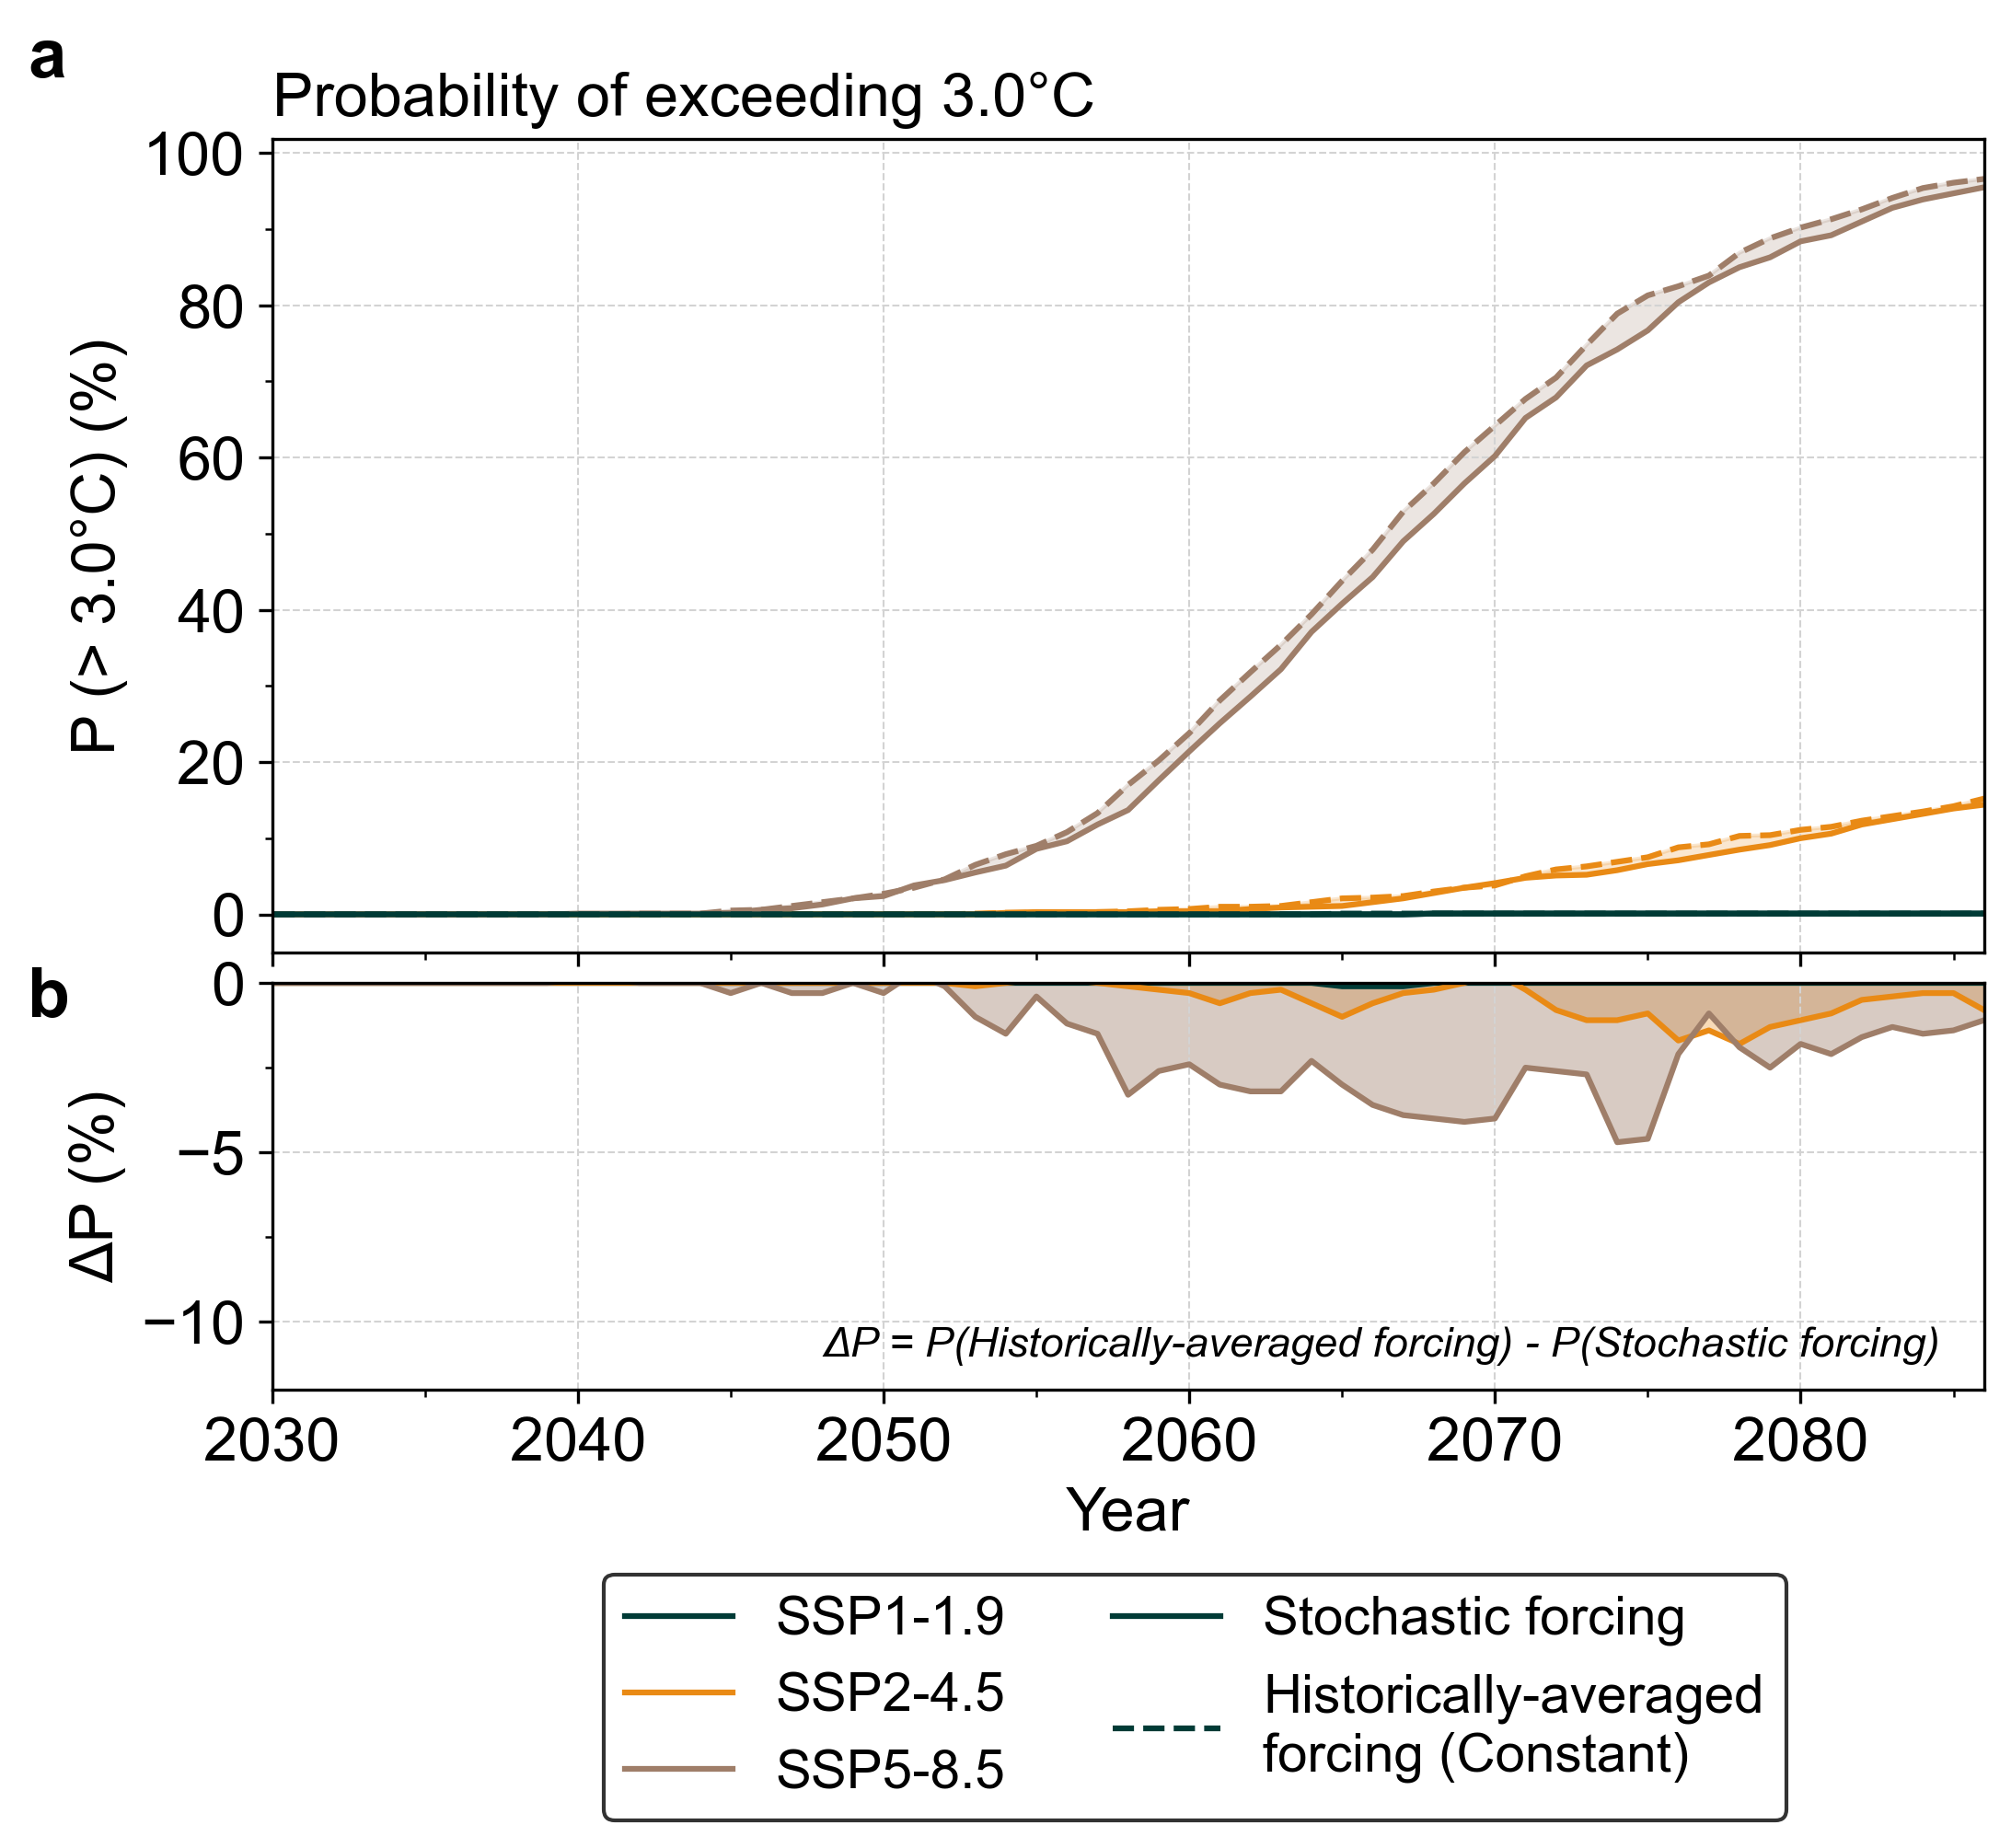

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=300, gridspec_kw={'height_ratios': [2, 1]})
grid_settings = {'color': 'lightgray', 'linestyle': '--', 'linewidth': 0.5}

plt.subplots_adjust(hspace=0.05)
ax1.grid(True, **grid_settings)
ax2.grid(True, **grid_settings)

ax1.minorticks_on()
ax2.minorticks_on()

ax1.xaxis.set_minor_locator(ticker.MultipleLocator(5)) 
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(10))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))


df = df2.temperature[165:,:,:].rolling(timebounds=30, center = True).mean()
const = dn.temperature[165:,:,:].rolling(timebounds=30, center = True).mean()

time = np.arange(2015,2102,1)

color = ['#003B36', '#E98A15', '#9F7E69']

temp = 3.0

ax1.plot(time, calc_prob_temp_threshold(df, 0, temp), color=color[0], lw = 1.5, label='SSP1-1.9')
ax1.fill_between(time, calc_prob_temp_threshold(df, 0, temp), calc_prob_temp_threshold(const, 0, temp), 
                 color=color[0], alpha=0.2)


ax1.fill_between(time, calc_prob_temp_threshold(df, 1, temp), calc_prob_temp_threshold(const, 1, temp), 
                 color=color[1], alpha=0.2)
ax1.plot(time, calc_prob_temp_threshold(df, 1, temp), color=color[1], lw = 1.5, label='SSP2-4.5')
ax1.plot(time, calc_prob_temp_threshold(const, 1, temp), color=color[1], lw = 1.5, ls='--')

ax1.fill_between(time, calc_prob_temp_threshold(df, 2, temp), calc_prob_temp_threshold(const, 2, temp), 
                 color=color[2], alpha=0.2)
ax1.plot(time, calc_prob_temp_threshold(df, 2, temp), color=color[2], lw = 1.5, label='SSP5-8.5')
ax1.plot(time, calc_prob_temp_threshold(const, 2, temp), color=color[2], lw = 1.5, ls='--')


ax1.plot(time, calc_prob_temp_threshold(df, 0, temp), color=color[0], lw = 1.5, label='Stochastic forcing')
ax1.plot(time, calc_prob_temp_threshold(const, 0, temp), color=color[0], lw = 1.5, ls='--', label='Historically-averaged\nforcing (Constant)')


ax1.set_ylabel('P (> 3.0°C) (%)')
ax1.set_xticklabels([])
ax1.legend(ncol=2, fontsize = 14, loc = 'lower right', frameon=True, bbox_to_anchor=(0.9, -1.1))
ax1.set_xlim(2030, 2086)
ax1.set_ylim(-5, )
ax1.set_title('Probability of exceeding 3.0°C', loc = 'left')

ax1.text(2022,110,'a', fontsize=18, fontweight='bold')
ax2.text(2022,-1,'b', fontsize=18, fontweight='bold')


prob_const = calc_prob_temp_threshold(const,0,temp)
prob_df = calc_prob_temp_threshold(df,0,temp)
diff = []
for x in range(87):
    diff.append(prob_df[x] - prob_const[x])

ax2.plot(time, diff, color =color[0], lw = 1.5, label = '3.0C, SSP1-1.9')
ax2.fill_between(time, 0, diff, color=color[0], alpha=0.2, label='SSP1-1.9')


prob_const = calc_prob_temp_threshold(const,1,temp)
prob_df = calc_prob_temp_threshold(df,1,temp)
diff = []
for x in range(87):
    diff.append(prob_df[x] - prob_const[x])

ax2.plot(time, diff, color =color[1], lw = 1.5, label = '3.0C, SSP2-4.5')
ax2.fill_between(time, 0, diff, color=color[1], alpha=0.3, label='SSP2-4.5')

prob_const = calc_prob_temp_threshold(const,2,temp)
prob_df = calc_prob_temp_threshold(df,2,temp)
diff = []
for x in range(87):
    diff.append(prob_df[x] - prob_const[x])

ax2.plot(time, diff, color =color[2], lw = 1.5, label = '3.0C, SSP5-8.5')
ax2.fill_between(time, 0, diff, color=color[2], alpha=0.4, label='SSP5-8.5')

ax2.text(2048, -11, 'ΔP = P(Historically-averaged forcing) - P(Stochastic forcing)', fontsize = 11, style = 'italic')

ax2.set_ylabel('ΔP (%)')
ax2.set_xlabel('Year')
ax2.set_xlim(2030, 2086)
ax2.set_ylim(-12, 0)

fig.savefig('FigureS2.pdf', format = 'pdf')

## Figure S3

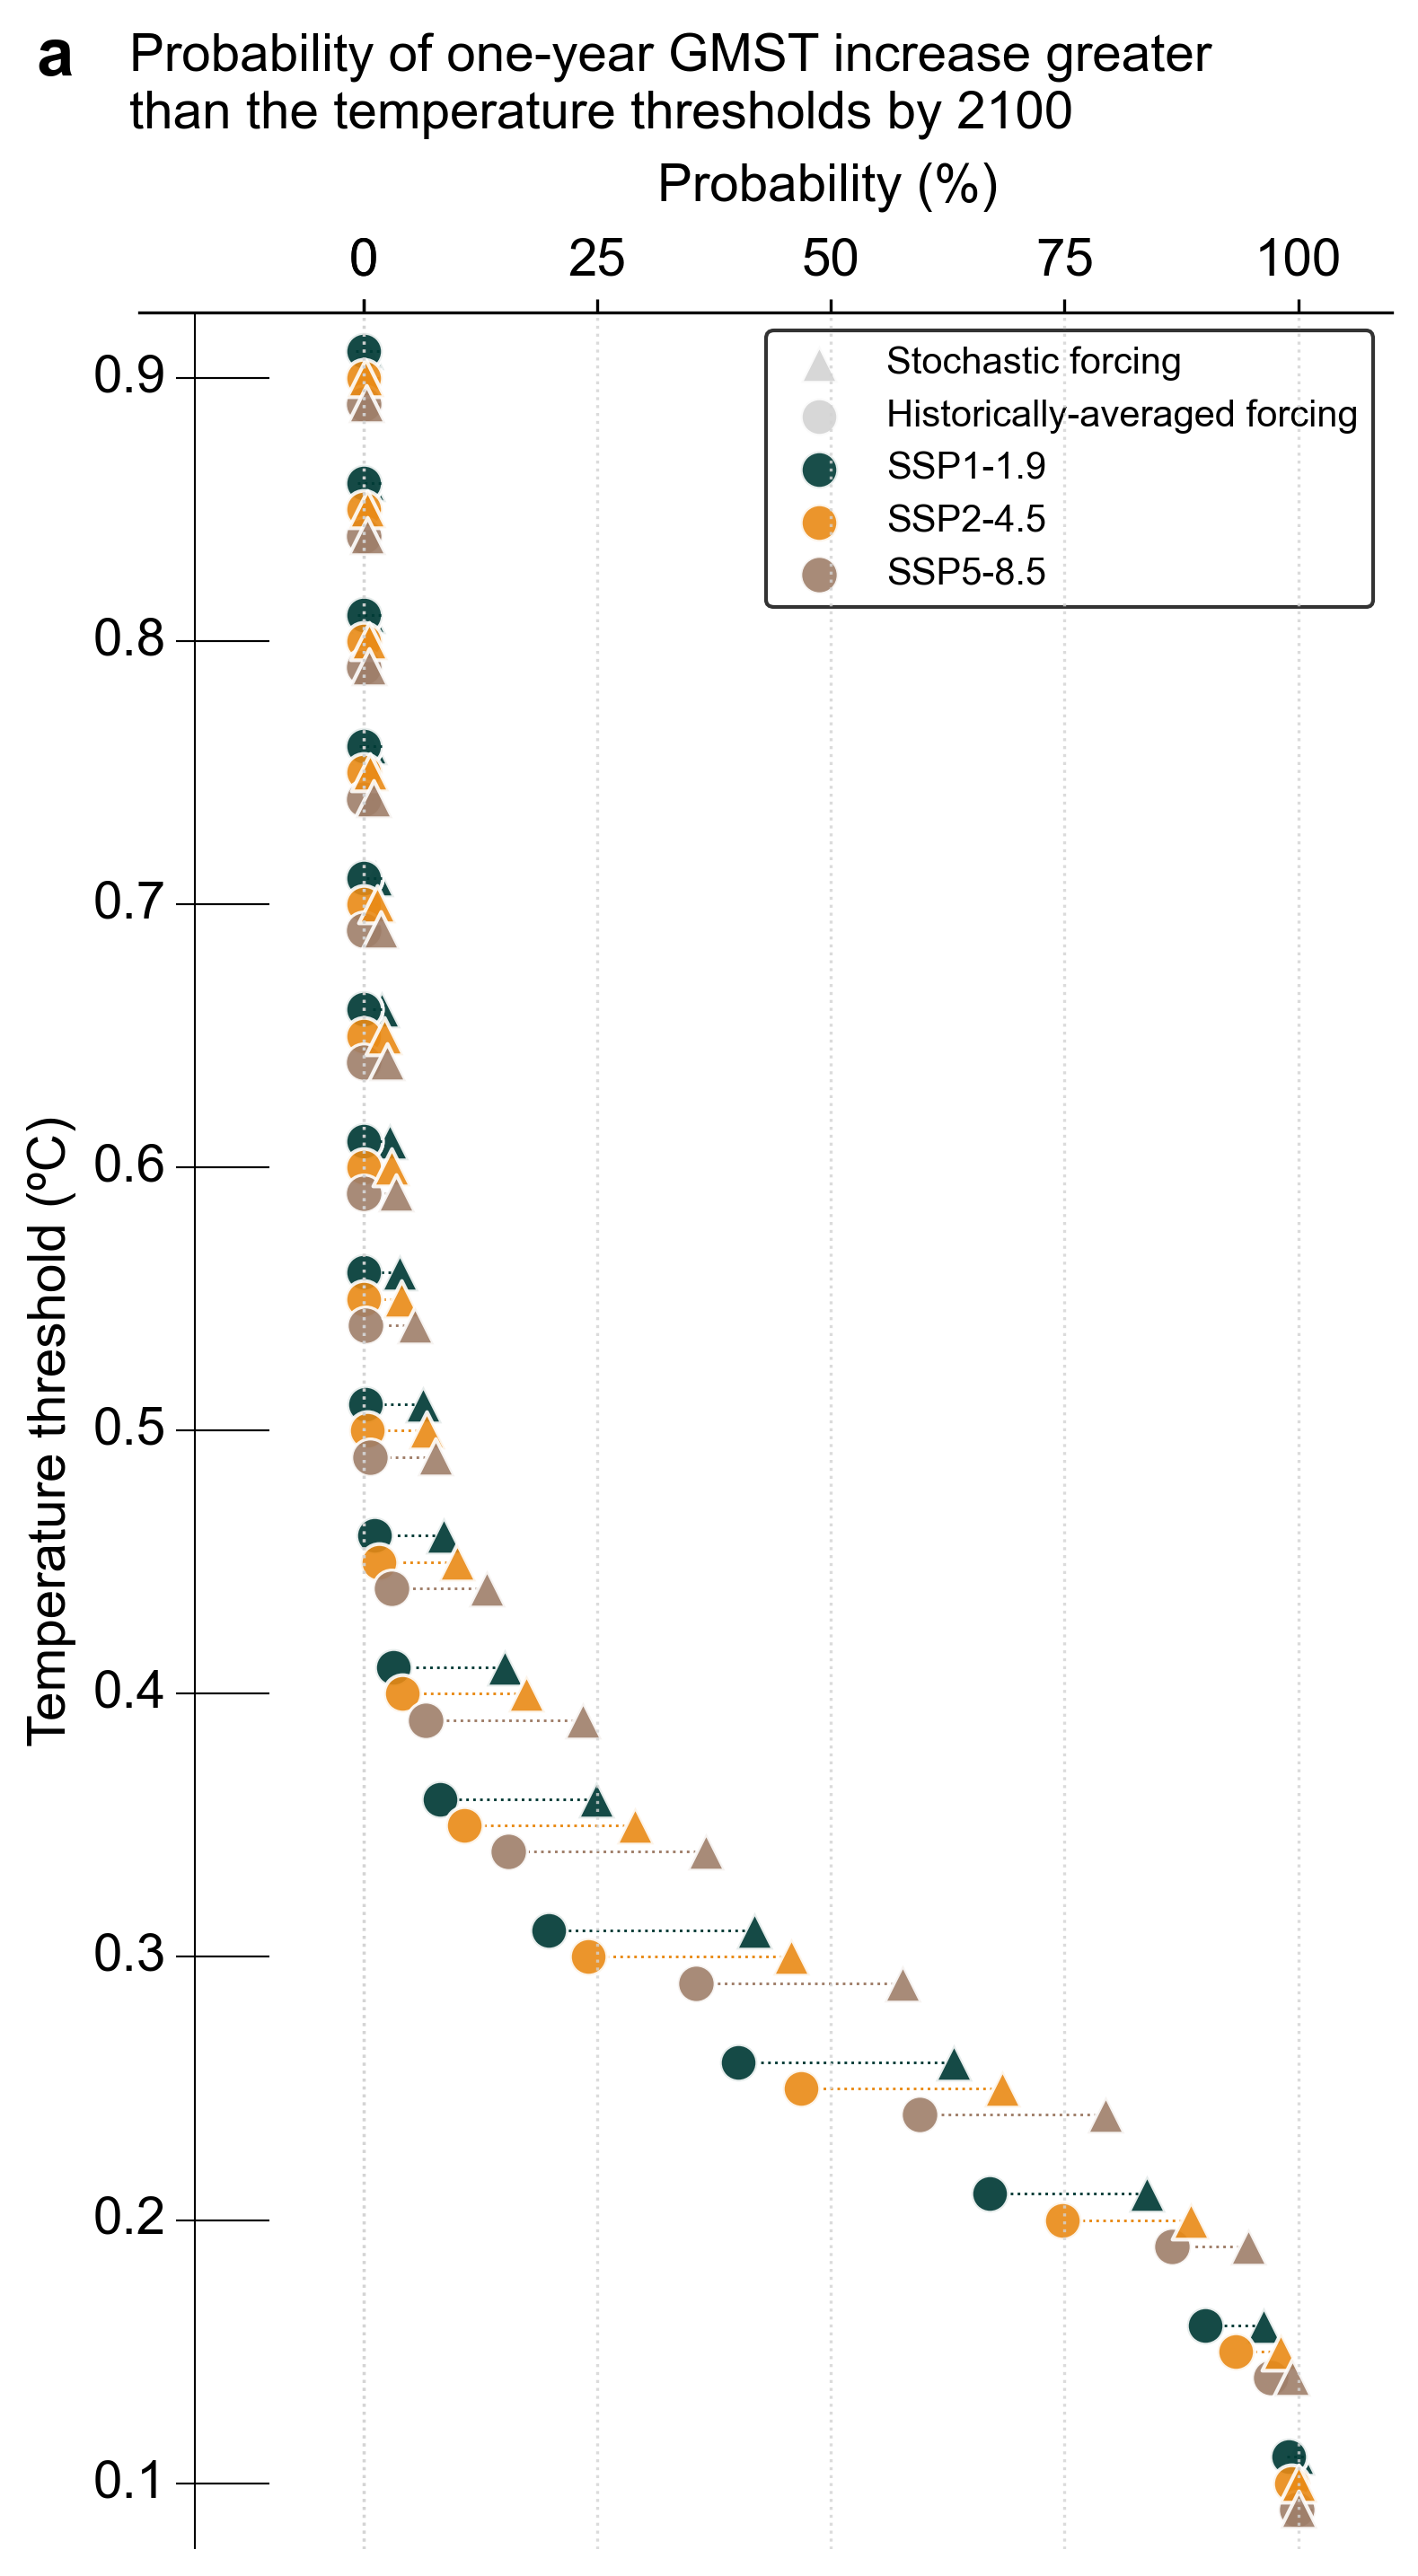

In [11]:
fig, ax1 = plt.subplots(figsize=(6, 11),dpi=300,frameon=False)
ax2 = ax1.twiny()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.grid(axis='x', color = 'lightgrey', alpha = 0.8, ls = 'dotted')

color = ['#003B36', '#E98A15', '#9F7E69']

index = df_occurrence['Temperature']

# For legend grey markers
ax1.scatter(df_occurrence['SSP1-1.9'], index+0.035, color = 'lightgrey', 
            s = 100, label = 'Stochastic forcing', marker = '^', ec = 'white', alpha = 0.9)
ax1.scatter(df_occurrence['SSP1-1.9'], index+0.035, color = color[0], 
            s = 100, marker = '^', ec = 'white', alpha = 0.9)

#ssp119
ax1.hlines(index+0.035, df_occurrence['SSP1-1.9']-1, df_occurrence['HIST_ssp119']+2, 
           color = color[0], lw = 0.7, ls ='dotted')

ax1.scatter(df_occurrence['HIST_ssp119'], index+0.035, color = 'lightgrey',
            label = 'Historically-averaged forcing', s = 100, marker = 'o', ec = 'white', alpha = 0.9)
ax1.scatter(df_occurrence['HIST_ssp119'], index+0.035, color = color[0], 
            label = 'SSP1-1.9', s = 100, marker = 'o', ec = 'white', alpha = 0.9)

#ssp245
ax1.hlines(index+0.025, df_occurrence['SSP2-4.5']-1, df_occurrence['HIST_ssp245']+2, 
           color = color[1], lw = 0.7, ls ='dotted')
ax1.scatter(df_occurrence['SSP2-4.5'], index+0.025,
            color = color[1], marker = '^', ec = 'white', zorder = 11, s = 100, alpha = 0.9)
ax1.scatter(df_occurrence['HIST_ssp245'], index+0.025, label = 'SSP2-4.5',
            color = color[1], s = 100, ec = 'white', marker = 'o', zorder = 10, alpha = 0.9)

#ssp585
ax1.hlines(index+0.015, df_occurrence['SSP5-8.5']-1, df_occurrence['HIST_ssp585']+2, 
           color = color[2], lw = 0.7, ls ='dotted')
ax1.scatter(df_occurrence['SSP5-8.5'], index+0.015, 
            color = color[2], marker = '^', ec = 'white', zorder = 11, s = 100, alpha = 0.9)
ax1.scatter(df_occurrence['HIST_ssp585'], index+0.015, color = color[2], label = 'SSP5-8.5',
            s = 100, ec = 'white', marker = 'o', zorder = 10, lw = 0.8, alpha = 0.9)

ax1.text(-35,1.04,'a', fontsize=18, fontweight='bold')
ax1.text(-25,1.02,'Probability of one-year GMST increase greater\nthan the temperature thresholds by 2100', fontsize=14)


y = np.arange(0.1, 0.91, 0.1)
x = np.linspace(0, 100, len(y))
for i, value in enumerate(y):
    if value >= 0.1:
        ax1.text(-25, value+0.025, f"{value:.1f}", ha="center", va="center", color="k", fontsize = 14)
        ax1.hlines(value+0.025, -20,-10, color = 'k', lw = 0.5)
        ax1.hlines(value+0.025, -20,-10, color = 'k', lw = 0.5)
        
ax1.vlines(-18, 5, -0.9, color='k', lw=0.5)

ax1.set_ylim(0.1, 0.95)
ax1.set_xlim(-24,110)
ax1.set_yticks([])


x_labels = [0,0,25,50,75,100]
ax1.set_xticklabels([])
ax1.set_xticks([])
ax2.set_xticklabels([])

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_labels)
ax2.set_xticklabels(x_labels, color='k', fontsize=14)
ax2.tick_params(axis='x', colors='k')
ax2.set_xlabel('Probability (%)', color='k', fontsize=14)
ax2.xaxis.set_label_coords(0.55, 1.05)

ax1.set_ylabel('Temperature threshold (ºC)', color = 'k', fontsize = 14)
ax1.yaxis.set_label_coords(-0.05,0.5)
ax1.legend(frameon=True, fontsize = 10, loc = 'upper right', labelcolor = 'k', facecolor = 'white')

fig.savefig('FigureS3a.pdf', format = 'pdf')

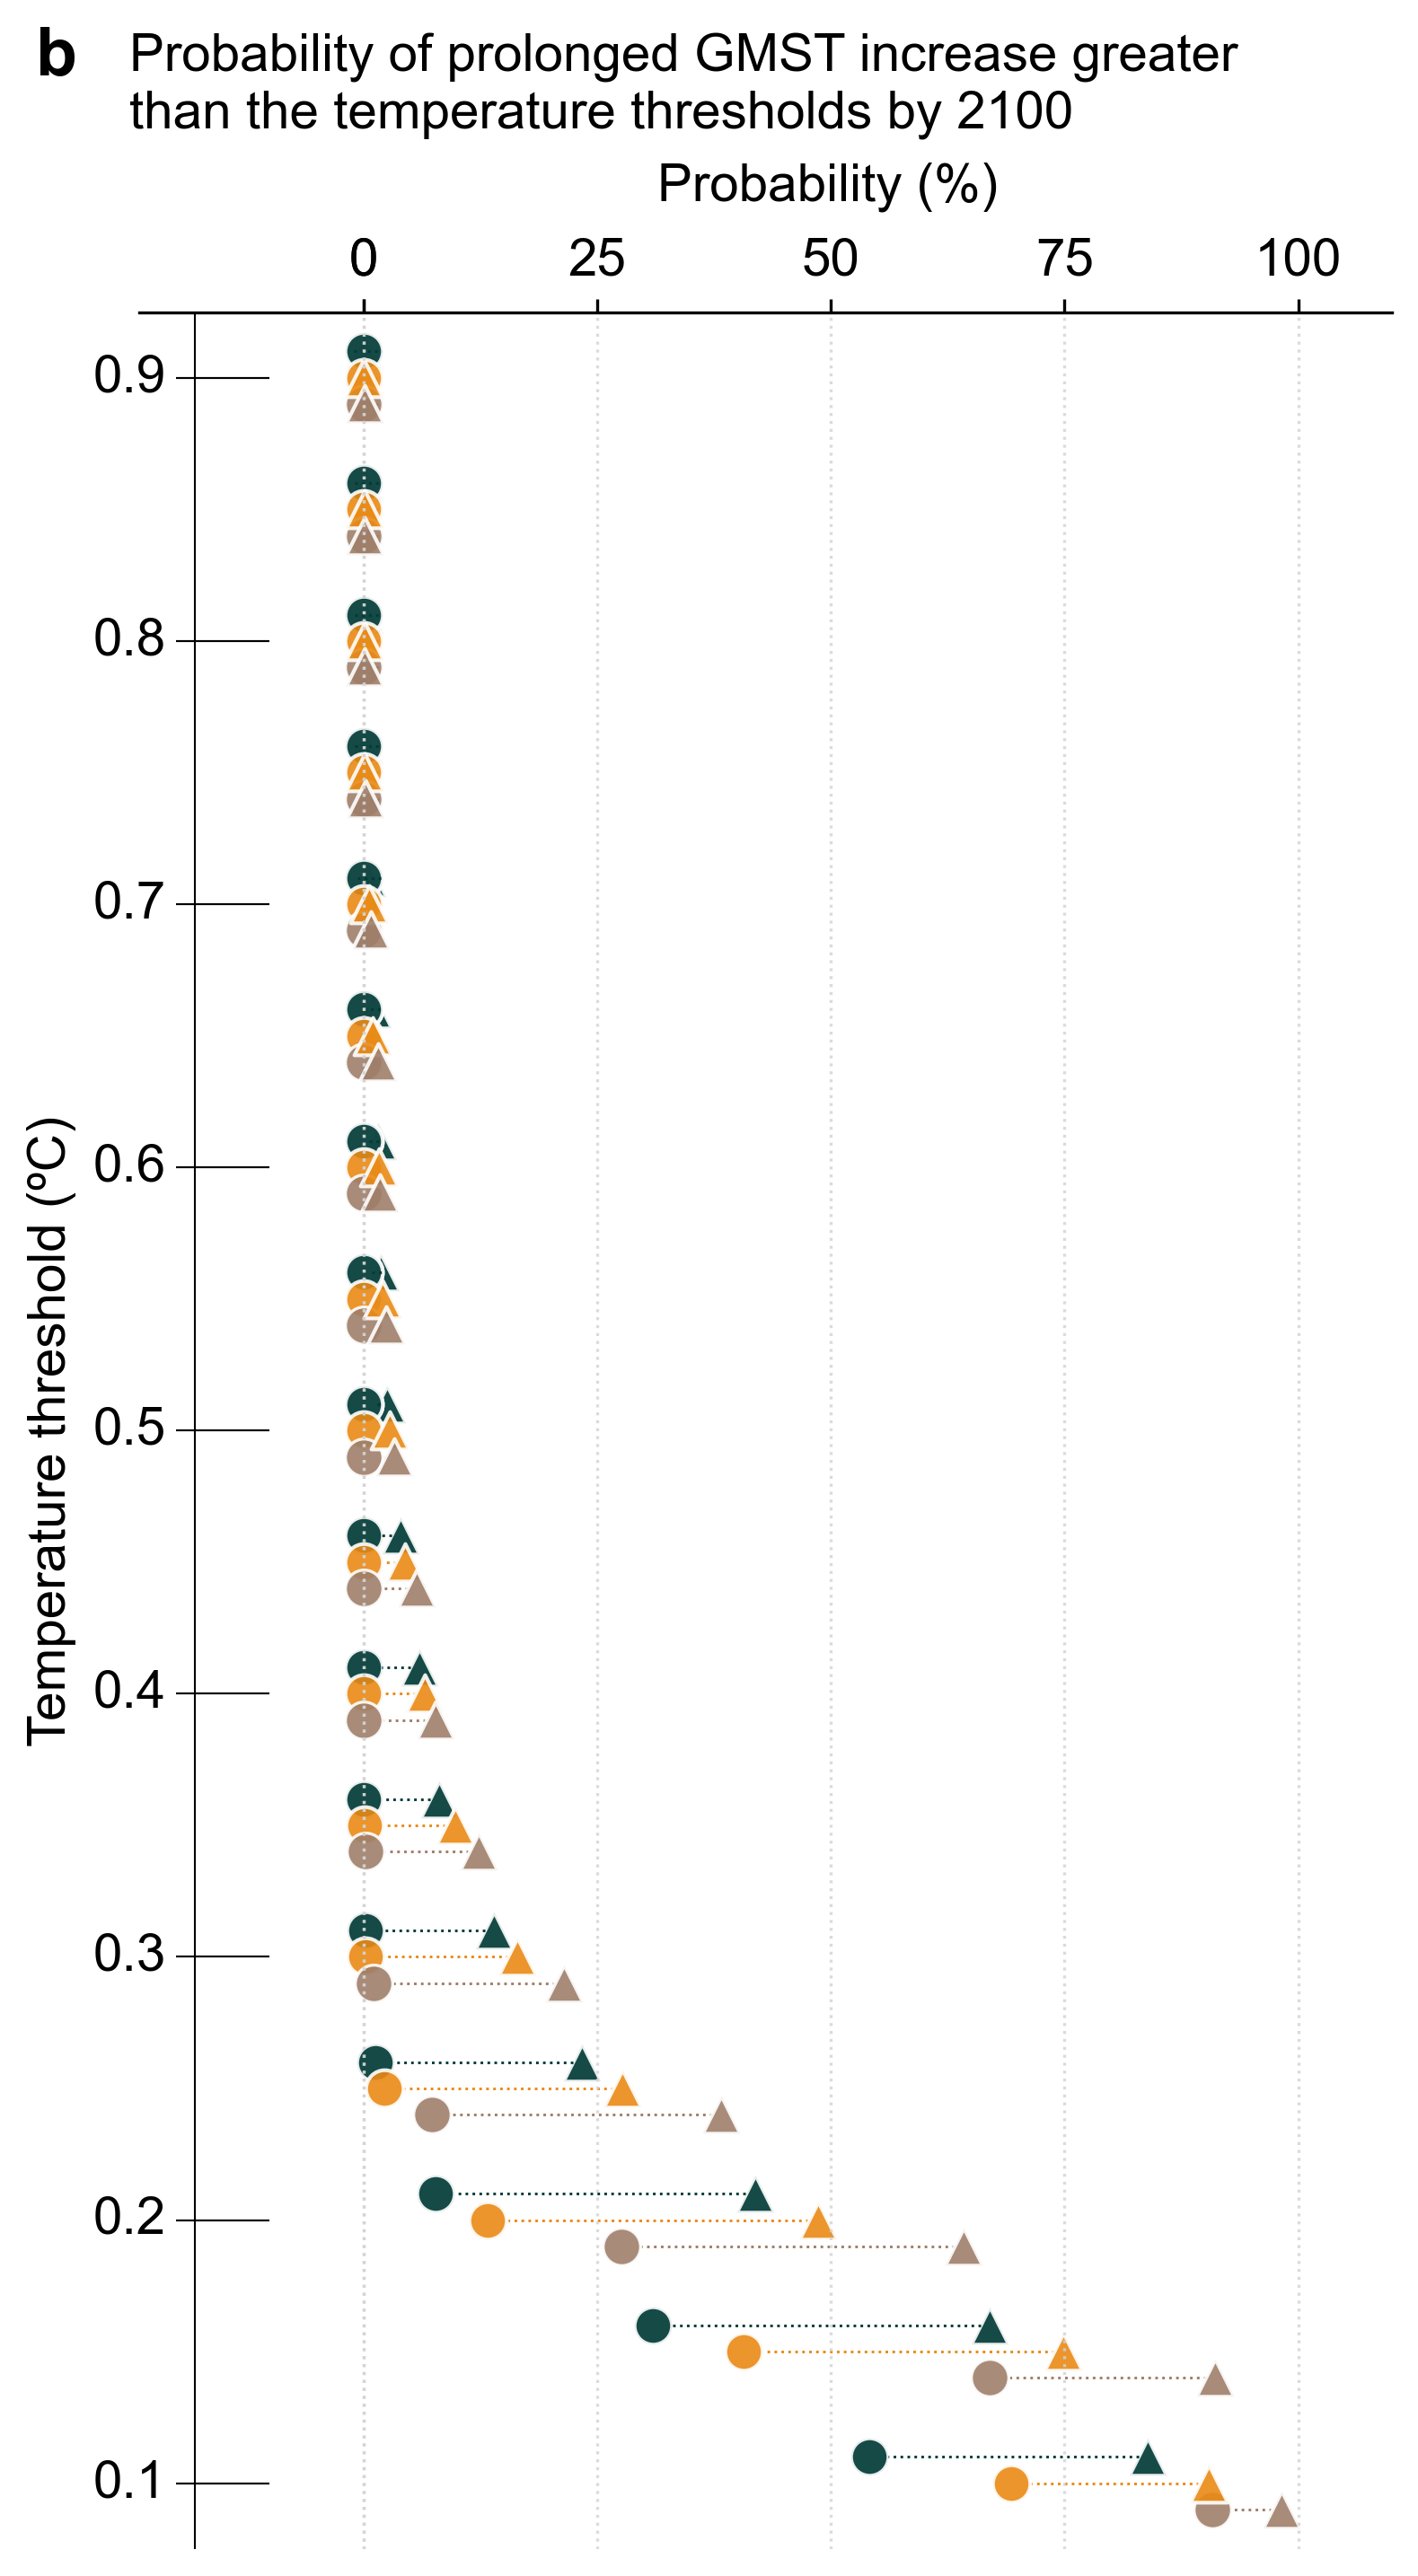

In [12]:
# Figure S3b

fig, ax1 = plt.subplots(figsize=(6, 11),dpi=300,frameon=False)
ax2 = ax1.twiny()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.grid(axis='x', color = 'lightgrey', alpha = 0.8, ls = 'dotted')

color = ['#003B36', '#E98A15', '#9F7E69']

index = df_prolonged_warming['Temperature']

# For legend grey markers
ax1.scatter(df_prolonged_warming['SSP1-1.9'], index+0.035, color = 'lightgrey', 
            s = 100, label = 'Stochastic forcing', marker = '^', ec = 'white', alpha = 0.9)
ax1.scatter(df_prolonged_warming['SSP1-1.9'], index+0.035, color = color[0], 
            s = 100, marker = '^', ec = 'white', alpha = 0.9)

#ssp119
ax1.hlines(index+0.035, df_prolonged_warming['SSP1-1.9']-1, df_prolonged_warming['HIST_ssp119']+2, 
           color = color[0], lw = 0.7, ls ='dotted')

ax1.scatter(df_prolonged_warming['HIST_ssp119'], index+0.035, color = 'lightgrey',
            label = 'Historically-averaged forcing', s = 100, marker = 'o', ec = 'white', alpha = 0.9)
ax1.scatter(df_prolonged_warming['HIST_ssp119'], index+0.035, color = color[0], 
            label = 'SSP1-1.9', s = 100, marker = 'o', ec = 'white', alpha = 0.9)

#ssp245
ax1.hlines(index+0.025, df_prolonged_warming['SSP2-4.5']-1, df_prolonged_warming['HIST_ssp245']+2, 
           color = color[1], lw = 0.7, ls ='dotted')
ax1.scatter(df_prolonged_warming['SSP2-4.5'], index+0.025,
            color = color[1], marker = '^', ec = 'white', zorder = 11, s = 100, alpha = 0.9)
ax1.scatter(df_prolonged_warming['HIST_ssp245'], index+0.025, label = 'SSP2-4.5',
            color = color[1], s = 100, ec = 'white', marker = 'o', zorder = 10, alpha = 0.9)

#ssp585
ax1.hlines(index+0.015, df_prolonged_warming['SSP5-8.5']-1, df_prolonged_warming['HIST_ssp585']+2, 
           color = color[2], lw = 0.7, ls ='dotted')
ax1.scatter(df_prolonged_warming['SSP5-8.5'], index+0.015, 
            color = color[2], marker = '^', ec = 'white', zorder = 11, s = 100, alpha = 0.9)
ax1.scatter(df_prolonged_warming['HIST_ssp585'], index+0.015, color = color[2], label = 'SSP5-8.5',
            s = 100, ec = 'white', marker = 'o', zorder = 10, lw = 0.8, alpha = 0.9)

ax1.text(-35,1.04,'b', fontsize=18, fontweight='bold')
ax1.text(-25,1.02,'Probability of prolonged GMST increase greater\nthan the temperature thresholds by 2100', fontsize=14)


y = np.arange(0.1, 0.91, 0.1)
x = np.linspace(0, 100, len(y))
for i, value in enumerate(y):
    if value >= 0.1:
        ax1.text(-25, value+0.025, f"{value:.1f}", ha="center", va="center", color="k", fontsize = 14)
        ax1.hlines(value+0.025, -20,-10, color = 'k', lw = 0.5)
        ax1.hlines(value+0.025, -20,-10, color = 'k', lw = 0.5)
        
ax1.vlines(-18, 5, -0.9, color='k', lw=0.5)

ax1.set_ylim(0.1, 0.95)
ax1.set_xlim(-24,110)
ax1.set_yticks([])


x_labels = [0,0,25,50,75,100]
ax1.set_xticklabels([])
ax1.set_xticks([])
ax2.set_xticklabels([])

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_labels)
ax2.set_xticklabels(x_labels, color='k', fontsize=14)
ax2.tick_params(axis='x', colors='k')
ax2.set_xlabel('Probability (%)', color='k', fontsize=14)
ax2.xaxis.set_label_coords(0.55, 1.05)

ax1.set_ylabel('Temperature threshold (ºC)', color = 'k', fontsize = 14)
ax1.yaxis.set_label_coords(-0.05,0.5)
#ax1.legend(frameon=True, fontsize = 10, loc = 'upper right', labelcolor = 'k', facecolor = 'white')

fig.savefig('FigureS3b.pdf', format = 'pdf')

## Figure S4

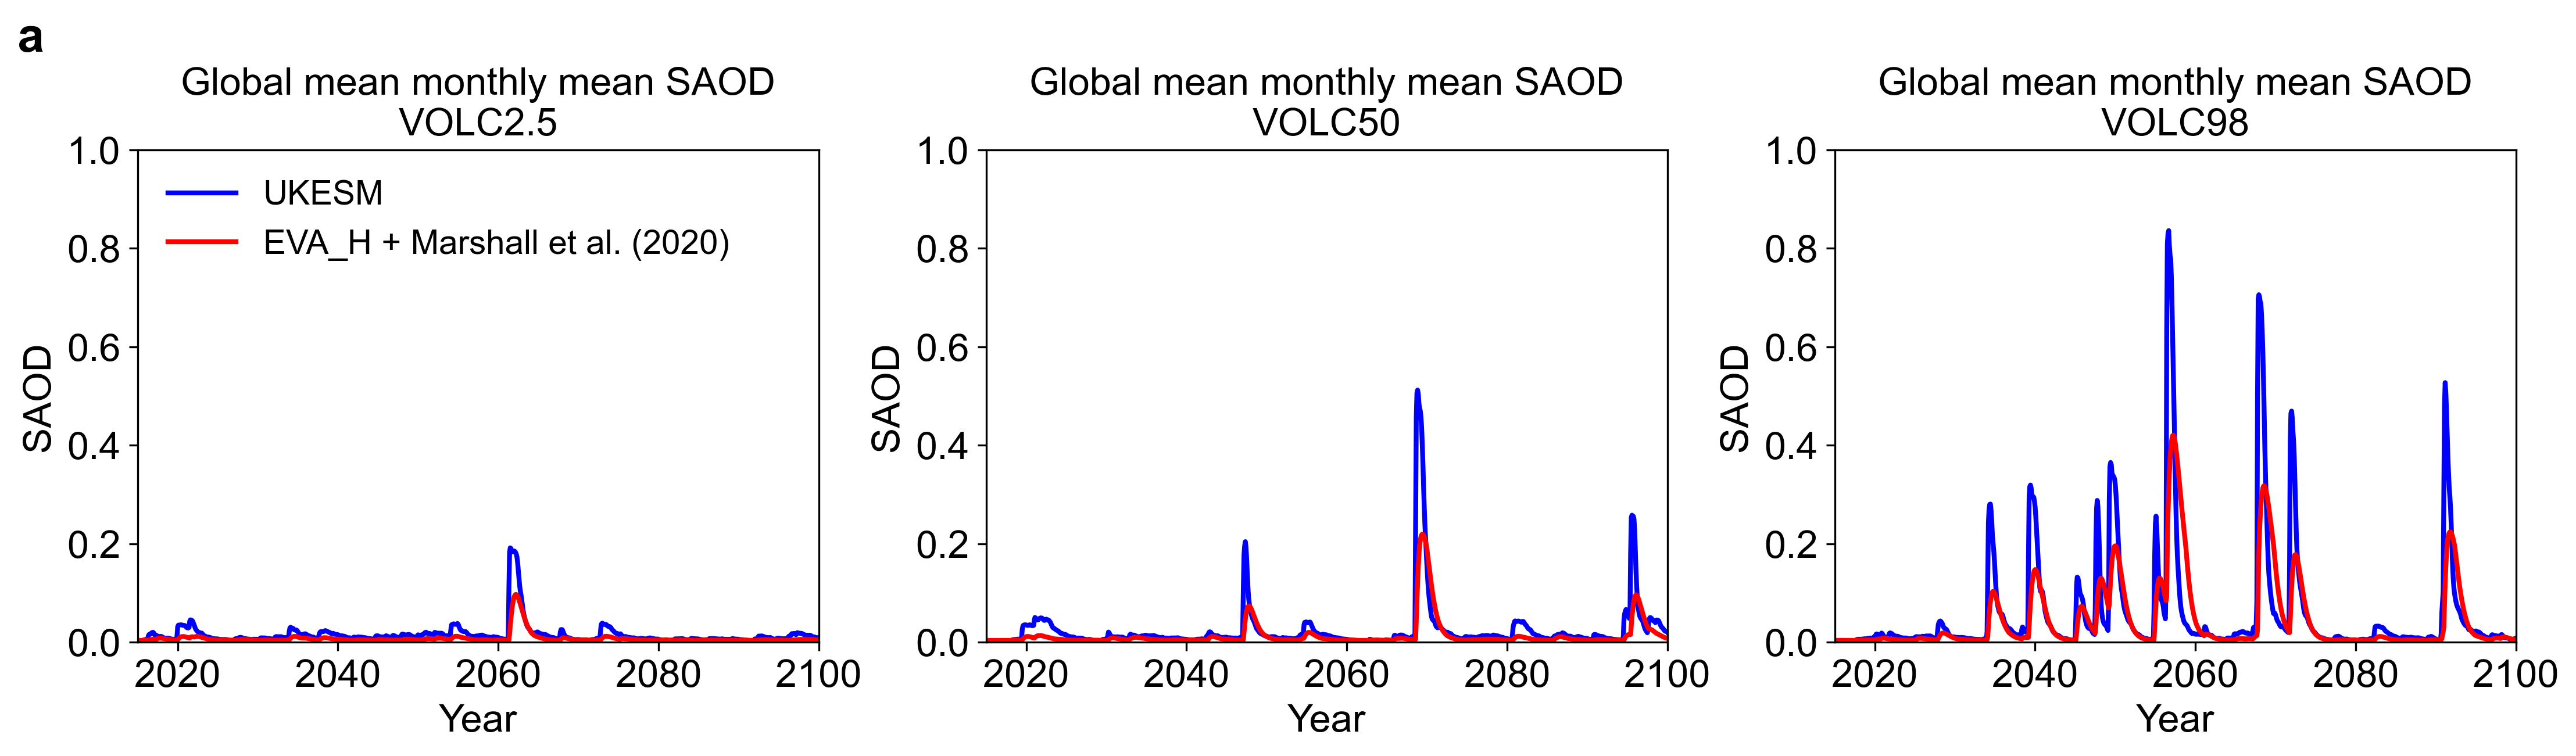

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), dpi=300, gridspec_kw={'width_ratios': [1.5,1.5,1.5]})
plt.tight_layout(pad=1.8)  

time = np.arange(2015,2101,1)

time_month = np.arange(2015,2101,1/12)

# left panel, VOLC2.5
ax1.plot(time_month, saod_volc25, label = 'UKESM', lw = 2, color = 'blue')
ax1.plot(time_month, saod_volc25_time_series, label = 'EVA_H + Marshall et al. (2020)', lw = 2, color = 'red')

ax1.legend(frameon=False, loc = 'upper left')
ax1.set_xlabel('Year')
ax1.set_ylabel('SAOD')
ax1.set_xlim(2015,2100)
ax1.set_ylim(0,1)
ax1.set_title('Global mean monthly mean SAOD\nVOLC2.5')

ax1.text(2000,1.2,'a', fontsize=20, fontweight='bold')

# middle panel, VOLC50
ax2.plot(time_month, saod_volc50_1, label = 'UKESM', lw = 2, color = 'blue')
ax2.plot(time_month, saod_volc50_time_series, label = 'FaIR', lw = 2, color = 'red')

ax2.set_xlabel('Year')
ax2.set_ylabel('SAOD')
ax2.set_xlim(2015,2100)
ax2.set_ylim(0,1)
ax2.set_title('Global mean monthly mean SAOD\nVOLC50')

# right panel, VOLC98
ax3.plot(time_month, saod_volc98, label = 'UKESM', lw = 2, color = 'blue')
ax3.plot(time_month, saod_volc98_time_series, label = 'FaIR', lw = 2, color = 'red')

ax3.set_xlabel('Year')
ax3.set_ylabel('SAOD')
ax3.set_xlim(2015,2100)
ax3.set_ylim(0,1)
ax3.set_title('Global mean monthly mean SAOD\nVOLC98')

fig.savefig('FigureS4a.pdf', format = 'pdf')


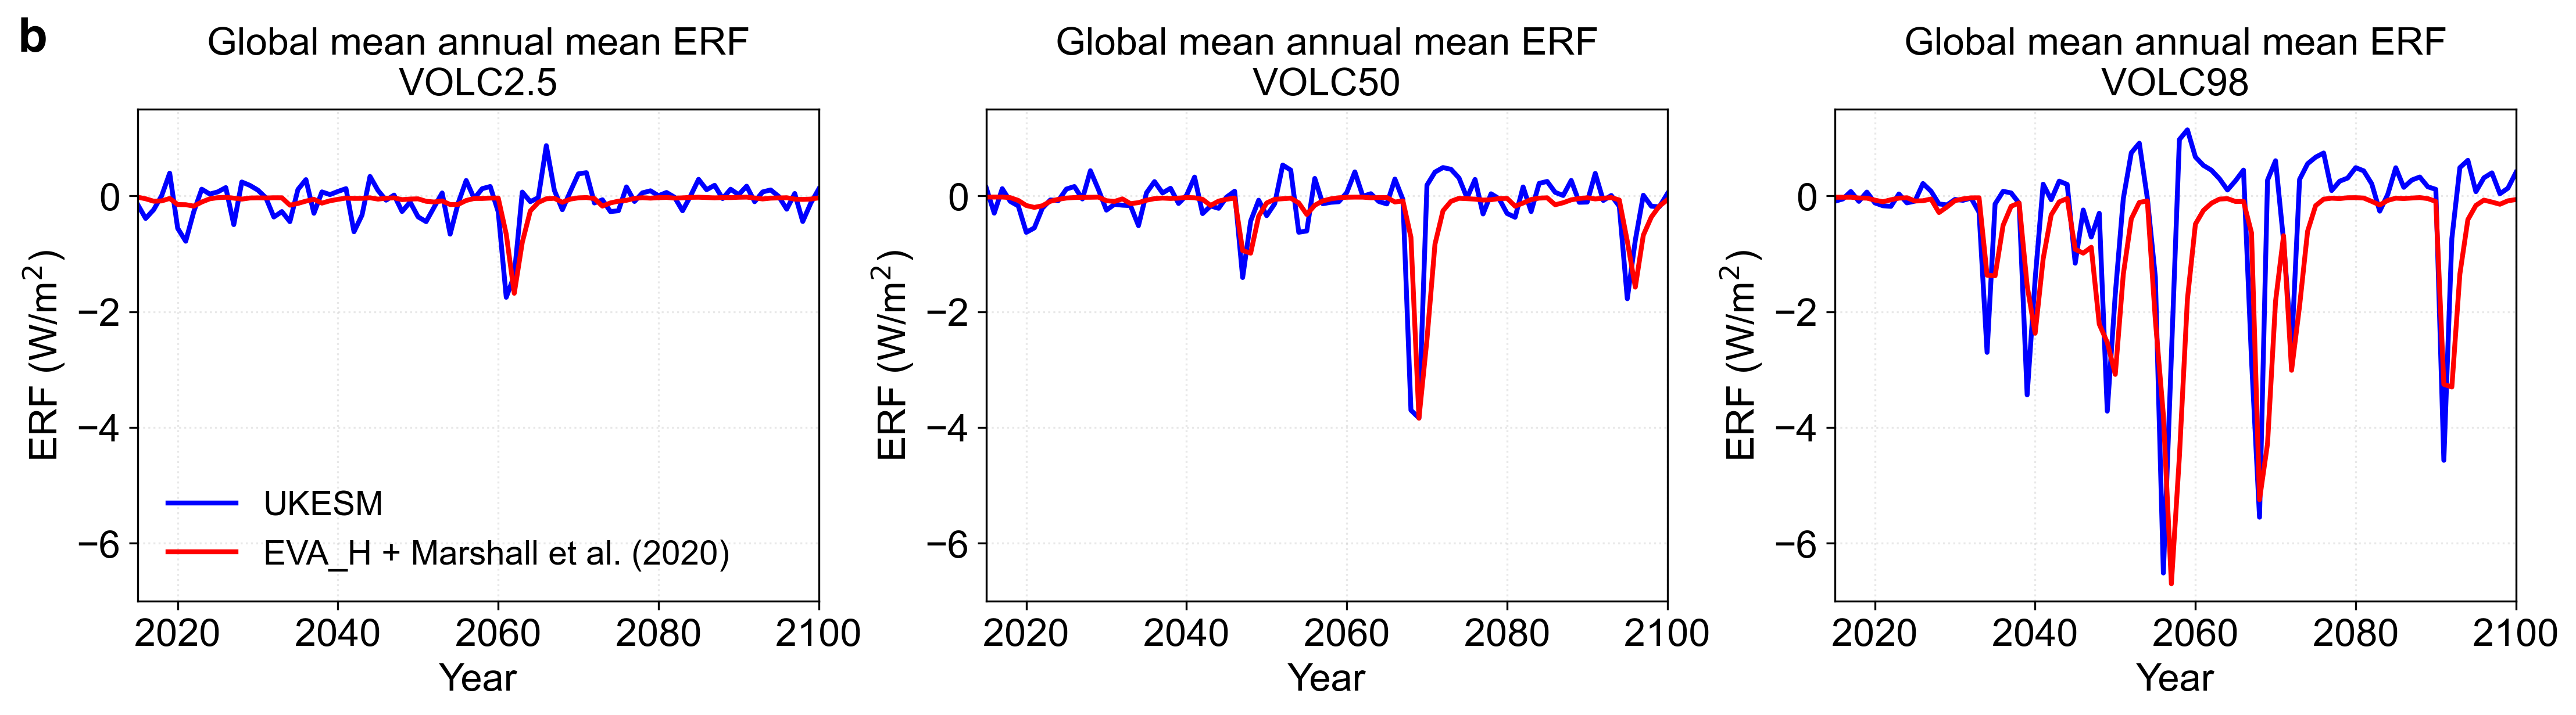

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), dpi=300, gridspec_kw={'width_ratios': [1.5,1.5,1.5]})
plt.tight_layout(pad=1.8)  

time = np.arange(2015,2101,1)
time_month = np.arange(2015,2101,1/12)

ax1.grid(axis = 'both', color = 'lightgrey', alpha = 0.5, ls = 'dotted')
ax2.grid(axis = 'both', color = 'lightgrey', alpha = 0.5, ls = 'dotted')
ax3.grid(axis = 'both', color = 'lightgrey', alpha = 0.5, ls = 'dotted')

# left panel, VOLC2.5
ax1.plot(time, RF_volc25-RF_novolc, label = 'UKESM', lw = 2, color = 'blue')
ax1.plot(time, erf_volc25_time_series, label = 'EVA_H + Marshall et al. (2020)', lw = 2, color = 'red')

ax1.legend(frameon=False, loc = 'lower left')
ax1.set_xlabel('Year')
ax1.set_ylabel('ERF (W/m$^2$)')
ax1.set_xlim(2015,2100)
ax1.set_ylim(-7, 1.5)
ax1.set_title('Global mean annual mean ERF\nVOLC2.5')

ax1.text(2000,2.5,'b', fontsize=20, fontweight='bold')

# middle panel, VOLC50
ax2.plot(time, RF_volc50_1-RF_novolc, label = 'UKESM', lw = 2, color = 'blue')
ax2.plot(time, erf_volc50_time_series, label = 'FaIR', lw = 2, color = 'red')

ax2.set_xlabel('Year')
ax2.set_ylabel('ERF (W/m$^2$)')
ax2.set_xlim(2015,2100)
ax2.set_ylim(-7, 1.5)
ax2.set_title('Global mean annual mean ERF\nVOLC50')

# right panel, VOLC98
ax3.plot(time, RF_volc98-RF_novolc, label = 'UKESM', lw = 2, color = 'blue')
ax3.plot(time, erf_volc98_time_series, label = 'FaIR', lw = 2, color = 'red')

ax3.set_xlabel('Year')
ax3.set_ylabel('ERF (W/m$^2$)')
ax3.set_xlim(2015,2100)
ax3.set_ylim(-7, 1.5)
ax3.set_title('Global mean annual mean ERF\nVOLC98')

fig.savefig('FigureS4b.pdf', format = 'pdf')


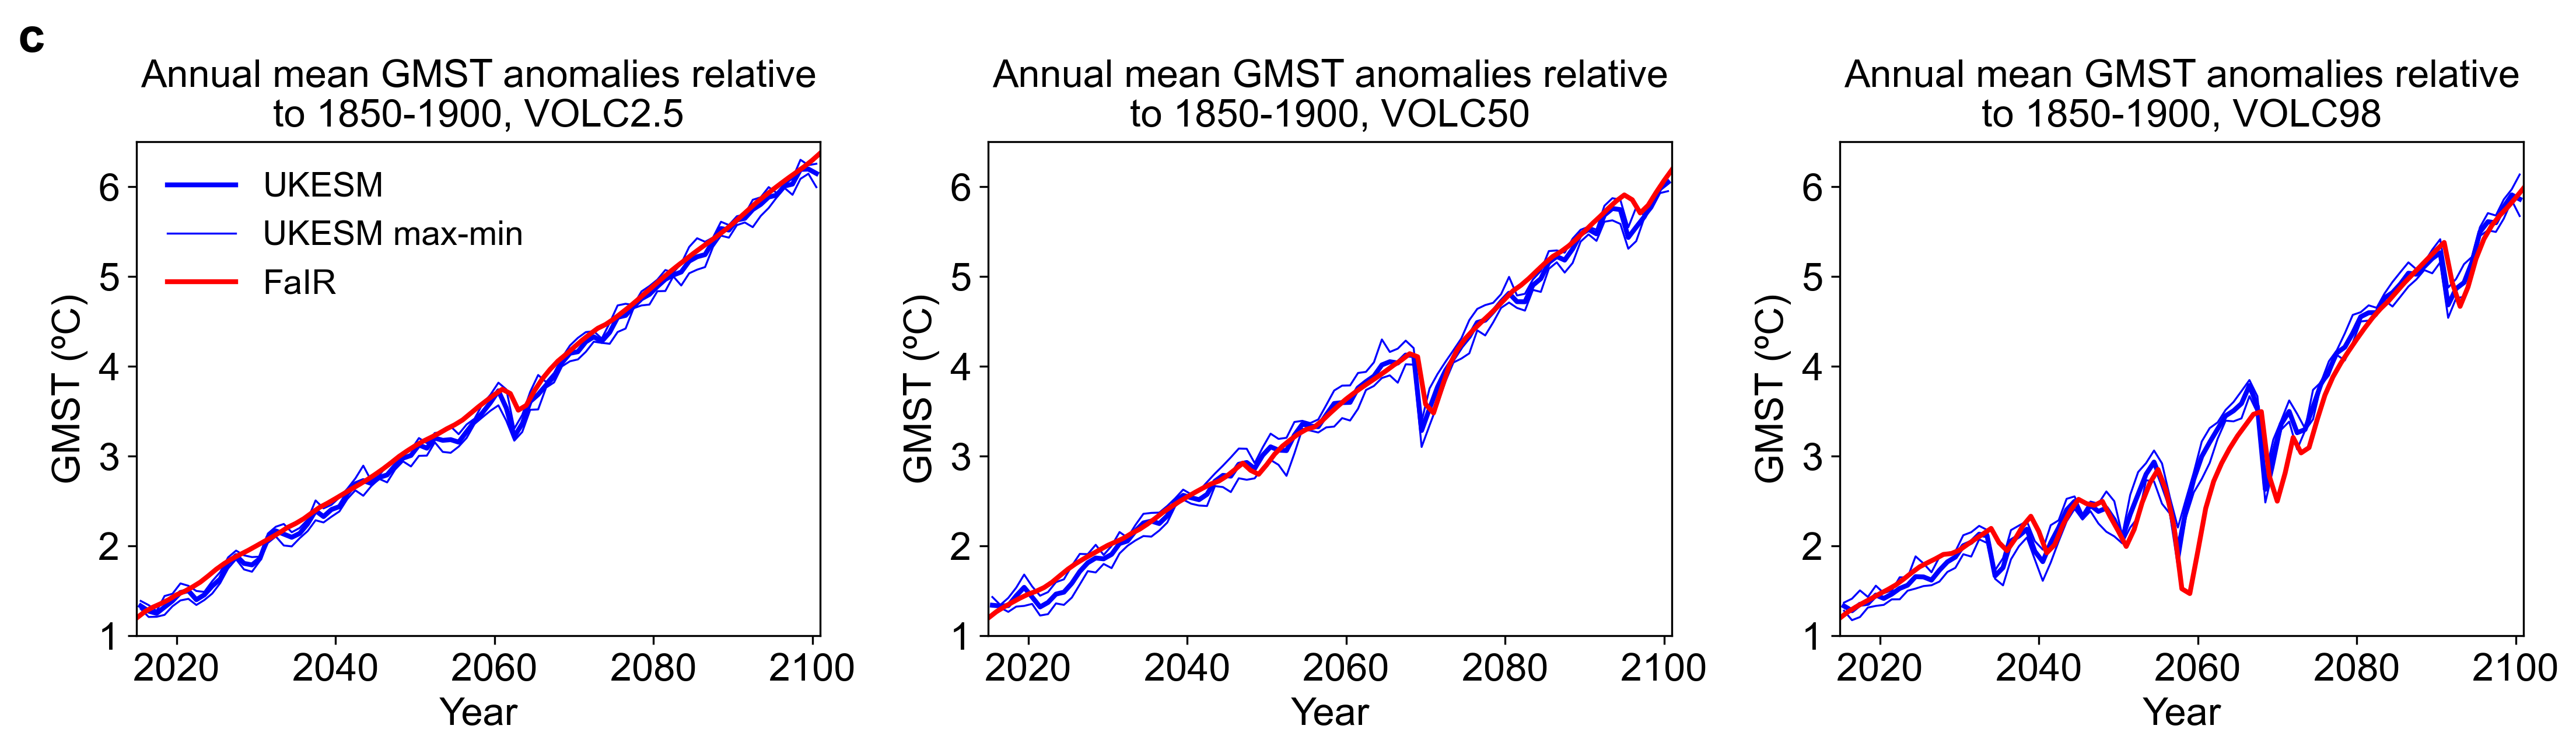

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), dpi=300, gridspec_kw={'width_ratios': [1.5,1.5,1.5]})
plt.tight_layout(pad=1.8)  

time = np.arange(2015.5,2101.5,1)
time2 = np.arange(2015,2102,1)

# Figure label
ax1.text(2000,7.5,'c', fontsize=20, fontweight='bold')

# left panel, VOLC2.5
ax1.plot(time, volc25_grl.air_temperature.mean(dim='Ensemble Member')-hist_ens, 
         lw = 2, color = 'blue', label = 'UKESM')
ax1.plot(time, volc25_grl.air_temperature.max(dim='Ensemble Member')-hist_ens, 
         lw = 0.8, color = 'blue', label = 'UKESM max-min')
ax1.plot(time, volc25_grl.air_temperature.min(dim='Ensemble Member')-hist_ens, 
         lw = 0.8, color = 'blue')
ax1.plot(time2, ukesm_cali.temperature[165:,0], 
         lw = 2, color = 'red', label = 'FaIR')

ax1.legend(frameon=False)
ax1.set_xlabel('Year')
ax1.set_ylabel('GMST (ºC)')
ax1.set_xlim(2015,2101)
ax1.set_ylim(1,6.5)
ax1.set_title('Annual mean GMST anomalies relative\nto 1850-1900, VOLC2.5')

# middle panel, VOLC50
ax2.plot(time, volc50_1_grl.air_temperature.mean(dim='Ensemble Member')-hist_ens, 
         lw = 2, color = 'blue', label = 'UKESM')
ax2.plot(time, volc50_1_grl.air_temperature.max(dim='Ensemble Member')-hist_ens, 
         lw = 0.8, color = 'blue', label = 'UKESM')
ax2.plot(time, volc50_1_grl.air_temperature.min(dim='Ensemble Member')-hist_ens, 
         lw = 0.8, color = 'blue', label = 'UKESM')
ax2.plot(time2, ukesm_cali.temperature[165:,2], 
         lw = 2, color = 'red', label = 'FaIR')

ax2.set_xlabel('Year')
ax2.set_ylabel('GMST (ºC)')
ax2.set_xlim(2015,2101)
ax2.set_ylim(1,6.5)
ax2.set_title('Annual mean GMST anomalies relative\nto 1850-1900, VOLC50')

# right panel, VOLC98
ax3.plot(time, volc98_grl.air_temperature.mean(dim='Ensemble Member')-hist_ens, 
         lw = 2, color = 'blue', label = 'UKESM')
ax3.plot(time, volc98_grl.air_temperature.max(dim='Ensemble Member')-hist_ens, 
         lw = 0.8, color = 'blue', label = 'UKESM')
ax3.plot(time, volc98_grl.air_temperature.min(dim='Ensemble Member')-hist_ens, 
         lw = 0.8, color = 'blue', label = 'UKESM')
ax3.plot(time2, ukesm_cali.temperature[165:,4], 
         lw = 2, color = 'red', label = 'FaIR')

ax3.set_xlabel('Year')
ax3.set_ylabel('GMST (ºC)')
ax3.set_xlim(2015,2101)
ax3.set_ylim(1,6.5)
ax3.set_title('Annual mean GMST anomalies relative\nto 1850-1900, VOLC98')

fig.savefig('FigureS4c.pdf', format = 'pdf')
